In [8]:
# ------------------------------------------------
# 
# sil vs cc data, 
# compares three simulations with the same 
# upstream aglime emissions but different upstream
# silicate emissions
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import os
import re
import glob

import cmocean.cm as cmo
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
import pandas as pd
import pickle
import xarray as xr

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# (002, 003, 004; or 007, 008, 009)
# EMISS LEVEL 1
fertLevel_1 = "hi"
idx_1 = "004"
tag_sil_1 = "basev1"

# EMISS LEVEL 2
fertLevel_2 = "hi"
idx_2 = "005"
tag_sil_2 = "basev1"

# EMISS LEVEL 3
fertLevel_3 = "hi"
idx_3 = "006"
tag_sil_3 = "basev1"


In [9]:
# ---- READ IN DATA
# EMISS LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))

# EMISS LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))

# EMISS LEVEL 3
datdir_3 = f"meanAnn_shortRun_{fertLevel_3}Fert_{tag_sil_3}_{idx_3}"    
datloc_3 = os.path.join(datpath, datdir_3)
# read in xr datasets
dssil3 = xr.open_dataset(os.path.join(datloc_3, 'ds_sil.nc'))
dscc3 = xr.open_dataset(os.path.join(datloc_3, 'ds_cc.nc'))
ds_anom3 = xr.open_dataset(os.path.join(datloc_3, 'ds_anom.nc'))

## Plot 1: Breakeven line for netR_noneg for each emissions scenario

In [10]:
ds_anom3

<xarray.Dataset> Size: 4MB
Dimensions:                  (loss_percent: 50, dustrate_ton_ha_yr: 14,
                              dustrad: 10, cdr_calc: 5, feedstock: 2)
Coordinates:
  * loss_percent             (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 112B 0.1 0.3 ... 100.0
  * dustrad                  (dustrad) int32 40B 1 10 30 50 ... 125 150 200 300
  * cdr_calc                 (cdr_calc) object 40B 'netR' ... 'conservative'
  * feedstock                (feedstock) object 16B 'cc' 'gbas'
Data variables:
    cdr_dif                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    cdr_adv                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    cdr_adv_plus_newSIC      (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    cdr_SIConly              (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_tot_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_adv_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_tot_tonHa_totcat  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_adv_tonHa_totcat  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    time_horizon             (feedstock) float64 16B ...
    cf_apprate               float64 8B ...
    cf_dustrad               int32 4B ...

(0.8, 100)

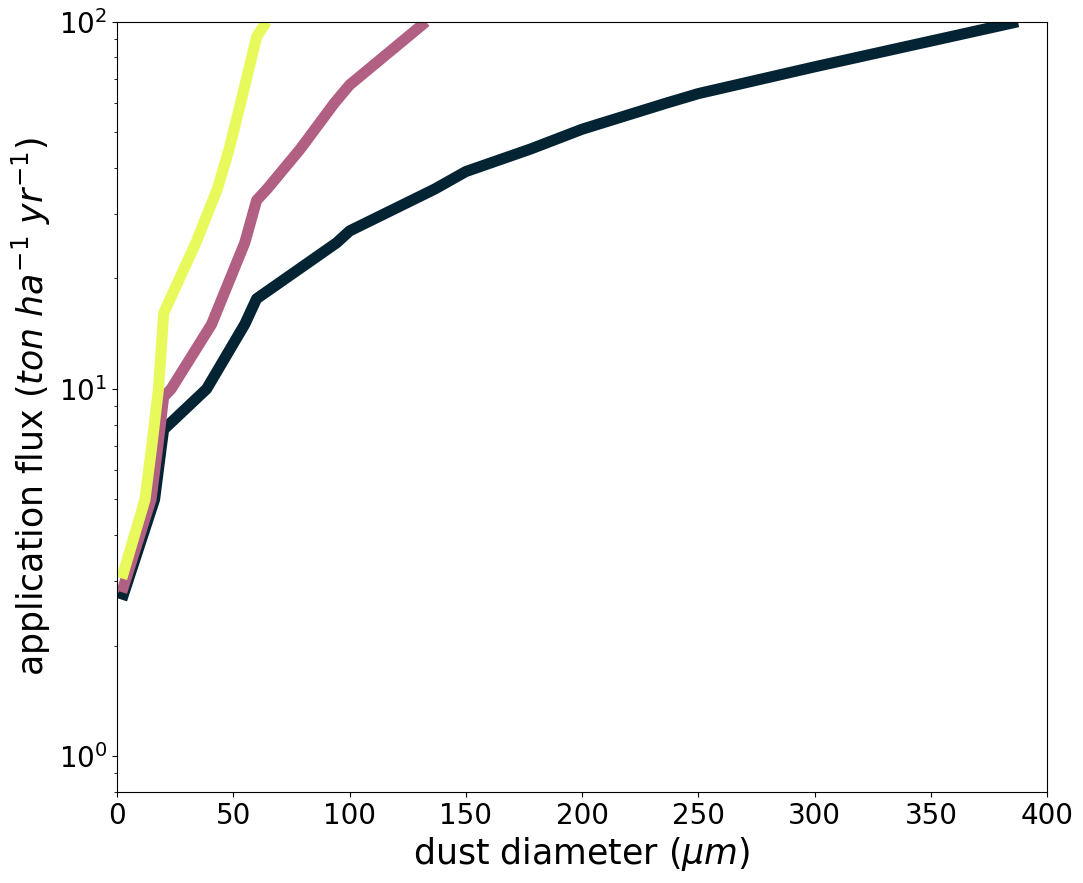

In [15]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 12
cdr_calc = 'simplesubtract_noNeg'
logX = False
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom3_p4 = ds_anom3.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
# also get the no emissions case
dsanom4_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc='netR_noNeg').sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom3_p4 = dsanom3_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom4_p4 = dsanom4_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 400
ymin, ymax = (0.8 if logY else 0), 100 
# *****************************

# x and y arrays
# [emisslevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# # [fertlevel 2]
# x2 = dsanom2_p4['dustrad'].values
# y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values

# get colors for the colormap
colormap = cmo.thermal
cols = [colormap(i) for i in np.linspace(0,1,3)]

# --- SET UP PLOT
spec = GridSpec(ncols=1, nrows=1)
plt.figure(figsize=(12,10))

# --- fertlevel 1
ax = plt.subplot(spec[0])
# contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
#                         levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
# no emissions line
contour_line = plt.contour(x1*2,y1,dsanom4_p4.transpose(),levels=[-0.01], colors='darkgray', linestyles='--', linewidths=5)
# accounting for emissions
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[-0.01], linestyles='solid', colors=cols[0], linewidths=8)
contour_line = plt.contour(x1*2,y1,dsanom2_p4.transpose(),levels=[-0.01], linestyles='solid', colors=cols[1], linewidths=8)
contour_line = plt.contour(x1*2,y1,dsanom3_p4.transpose(),levels=[-0.01], linestyles='solid', colors=cols[2], linewidths=8)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


In [34]:
cols

[(np.float64(0.015556013331540799),
  np.float64(0.13824424546464084),
  np.float64(0.2018108864558305),
  np.float64(1.0)),
 (np.float64(0.6922877457570544),
  np.float64(0.37358400614116233),
  np.float64(0.5085135225034096),
  np.float64(1.0)),
 (np.float64(0.9090418416674036),
  np.float64(0.9821574063216706),
  np.float64(0.3555078064299531),
  np.float64(1.0))]

In [ ]:
# -----